# Accessibility Analysis

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 100m grid blocks coming from WorldPop
- the accessibility measure is the distance to the nearest facility in meters

## Inputs:

#### origins: derived from a WorldPOP raster using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [3]:
# Get reference to GOSTNets
sys.path.append(r'C:\\Users\\Rosem\\Documents\\Career\\World Bank\\City Scan\\repo\\GOSTnets')
import GOSTnets as gn

In [4]:
from GOSTnets.fetch_pois import *

### Define folders and files

In [5]:
inputFolder = r'input_folder'
# define output folder
outputFolder = r'output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [6]:
city_name = 'sarajevo'

In [7]:
# import extent
extent = gpd.read_file("./admin/" + city_name + "_AOI.shp").set_crs(epsg=4326)

In [8]:
# make sure crs is 4326
print(extent.crs)

epsg:4326


In [9]:
#extent = box(*city_extent.total_bounds)

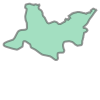

In [10]:
extent.geometry[0]

## We will extract OSM POIs

In [11]:
school_tags = {'amenity':['school', 'kindergarten', 'university', 'college']}
# Removing pharmacy from health_tags
health_tags = {'amenity':['clinic', 'hospital', 'health']}
police_tags = {'amenity':['police']}
fire_station_tags = {'amenity':['fire_station']}

In [12]:
tag_dictionary = {'schools': school_tags, 'health': health_tags, 'police': police_tags, 'fire': fire_station_tags}

In [13]:
try:
    os.mkdir(outputFolder + '/osm_infrastructure')
except FileExistsError:
    pass

In [14]:
queries = {}
for tags in tag_dictionary.items():
    print(tags[0])
    # create the OsmObject
    queries[tags[0]] = OsmObject(f'{tags[0]}', extent.geometry[0].buffer(0), tags[1])
query_results_gpd_dict = {}
for query in queries.items():
    print(query)
    result = query[1].GenerateOSMPOIs()
    
    # if query is not empty
    if result.empty == False:
        
        query[1].RemoveDupes(0.0005)
        
        #print(query[1].df)

        if 'name' in query[1].df.columns:
            query_results = query[1].df[['amenity','geometry','name']]
        else:
            query_results = query[1].df[['amenity','geometry']]

        # convert to GeoDataFrame
        query_results_gpd = gpd.GeoDataFrame(query_results, crs = "epsg:4326", geometry = 'geometry')
        query_results_gpd.to_file(outputFolder + f'/osm_infrastructure/osm_{query[0]}.shp')

        #save result in query_results_gpd_dict 
        query_results_gpd_dict[query[0]] = query_results_gpd

schools
health
police
fire
('schools', <GOSTnets.fetch_pois.OsmObject object at 0x000001E726BD8B50>)


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:95: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise t

('health', <GOSTnets.fetch_pois.OsmObject object at 0x000001E726BD8460>)


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:95: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geo

('police', <GOSTnets.fetch_pois.OsmObject object at 0x000001E726BEC3A0>)


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

('fire', <GOSTnets.fetch_pois.OsmObject object at 0x000001E726BEC310>)


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\gostnets-1.0.1-py3.9.egg\GOSTnets\fetch_pois.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

## We will extract the Roads and convert into a graph

In [15]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largest subgraph
   
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph

    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
<class 'networkx.utils.decorators.argmap'> compilation 21:5: DeprecationWarning: write_gpickle is deprecated and will be removed in 3.0.Use ``pickle.dump(G, path, protocol)``


### Inspect the road graph as a shapefile

In [16]:
roads = gn.edge_gdf_from_graph(G)

In [17]:
pd.set_option('display.max_columns', None)

### Sometimes the highway value can have a list instead of a single value, in these cases the code below will replace the list with the first value of the list

In [18]:
def replace_hwy(x):
    if isinstance(x, list):
        x = x[0]
    return x

In [19]:
roads['highway'] = roads.apply(lambda x: replace_hwy(x['highway']), axis=1)

In [20]:
roads[:2]

,stnode,endnode,time,mode,highway,bridge,service,access,junction,tunnel,ref,length,width,osmid,lanes,maxspeed,name,oneway,geometry
0,32271249,253041617,33.08598,drive,residential,NaN,NaN,NaN,NaN,NaN,NaN,183.811,NaN,23370195,NaN,NaN,Branka Radičevića,False,"LINESTRING (18.38119 43.80148, 18.38107 43.801..."
1,32271249,32271250,56.05254,drive,residential,NaN,NaN,NaN,NaN,NaN,NaN,311.403,NaN,929265833,NaN,NaN,Mladička,False,"LINESTRING (18.38119 43.80148, 18.38008 43.801..."


In [21]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    #roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

### Snap destinations to the road graph

In [22]:
snapped_destinations_dict = {}
for results_gpd in query_results_gpd_dict.items():
    snapped_destinations = gn.pandana_snap(G, query_results_gpd_dict[results_gpd[0]])
    snapped_destinations_dict[results_gpd[0]] = list(snapped_destinations['NN'].unique())

In [23]:
# snapped_destinations_dict

## Isochrones processing

In [24]:
threshold_list = {
    'schools': [800,1600,2400],
    'health': [1000,2000,3000]
}

In [25]:
# find graph utm zone
G_utm = gn.utm_of_graph(G)

In [26]:
def isochrone_processing(amenity_type):
    amenity_threshold_list = threshold_list.get(amenity_type)
    if amenity_threshold_list == None:
        return "Amenity type not found"
    # if no destinations for amenity type exist
    if snapped_destinations_dict.get(amenity_type) == None:
        print(f"no destinations for {amenity_type} exist")
    else:
        for threshold in amenity_threshold_list:
            print(threshold)
            iso_gdf = gn.make_iso_polys(G, snapped_destinations_dict[amenity_type], [threshold], edge_buff=300, node_buff=300, weight = 'length', measure_crs = G_utm)
            dissolved = iso_gdf.dissolve(by="thresh")
            gdf_out = dissolved.explode()
            gdf_out2 = gdf_out.reset_index()
            # save file
            gdf_out2.to_file(outputFolder + f'/{city_name}_AOI_accessibility_{amenity_type}_isochrones_{threshold}m.shp')
        

In [27]:
for key in threshold_list:
    print(key)
    isochrone_processing(key)

schools
800
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetchin

1600
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetchin

2400
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetchin

health
1000
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetchin

2000
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetchin

3000
merge all edges and nodes


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


unary_union


C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\pandas\core\dtypes\cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
C:\Users\Rosem\anaconda3\envs\cityscan\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetchin